In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import nltk
import seaborn as sns

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
df = pd.read_csv("spam.csv", encoding="latin-1")

df.sample(5)
df.shape

(5572, 5)

In [8]:
df = df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])#dropping unnecessary columns


In [9]:
df.rename(columns={'v1':'spam','v2':'message'},inplace=True)#renaming columns
#label encoding the spam column
encoder = LabelEncoder()
df['spam']=encoder.fit_transform(df['spam']) #0 means not spam and 1 means yes spam.
df.info

<bound method DataFrame.info of       spam                                            message
0        0  Go until jurong point, crazy.. Available only ...
1        0                      Ok lar... Joking wif u oni...
2        1  Free entry in 2 a wkly comp to win FA Cup fina...
3        0  U dun say so early hor... U c already then say...
4        0  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567     1  This is the 2nd time we have tried 2 contact u...
5568     0              Will Ì_ b going to esplanade fr home?
5569     0  Pity, * was in mood for that. So...any other s...
5570     0  The guy did some bitching but I acted like i'd...
5571     0                         Rofl. Its true to its name

[5572 rows x 2 columns]>

In [12]:
df.isnull().sum()
#checking for duplicate values
df.duplicated().sum()
df = df.drop_duplicates(keep='first')


In [13]:
df['spam'].value_counts() # this tells me what ratio of the values = imbalanced dataset

0    4516
1     653
Name: spam, dtype: int64

In [14]:
df = df.assign(char_message=df['message'].apply(len))


In [15]:
df['message'].apply(lambda x:nltk.word_tokenize(x)) #this divides the sentences into words.

0       [Go, until, jurong, point, ,, crazy, .., Avail...
1                [Ok, lar, ..., Joking, wif, u, oni, ...]
2       [Free, entry, in, 2, a, wkly, comp, to, win, F...
3       [U, dun, say, so, early, hor, ..., U, c, alrea...
4       [Nah, I, do, n't, think, he, goes, to, usf, ,,...
                              ...                        
5567    [This, is, the, 2nd, time, we, have, tried, 2,...
5568     [Will, Ì_, b, going, to, esplanade, fr, home, ?]
5569    [Pity, ,, *, was, in, mood, for, that, ., So, ...
5570    [The, guy, did, some, bitching, but, I, acted,...
5571                  [Rofl, ., Its, true, to, its, name]
Name: message, Length: 5169, dtype: object

In [16]:
df = df.assign(words_message = df['message'].apply(lambda x:len(nltk.word_tokenize(x))))

In [17]:
df = df.assign(sentence_message = df['message'].apply(lambda x:len(nltk.sent_tokenize(x))))

<Axes: xlabel='char_message', ylabel='Count'>

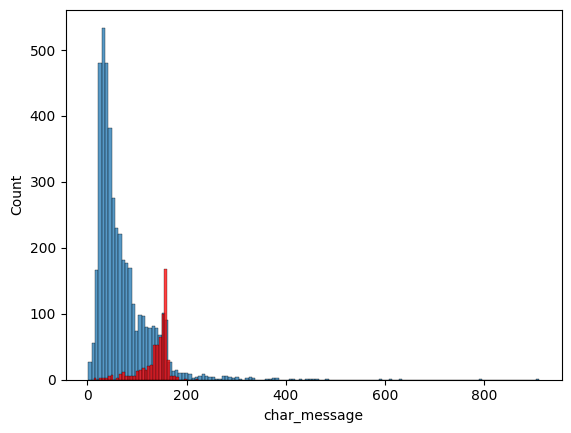

In [18]:
#now understanding how the characters , words and sentences vary for spam and non spam messages..
sns.histplot(df[df['spam'] == 0]['char_message'])
sns.histplot(df[df['spam'] == 1]['char_message'],color='red')

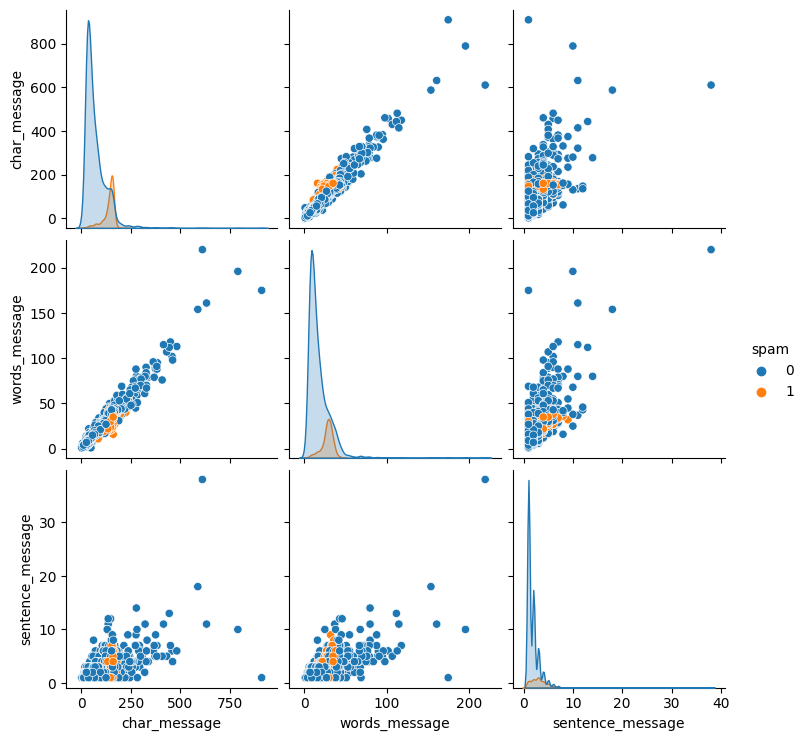

In [19]:
sns.pairplot(df,hue='spam')


the above pairplot tells us that there are outliers in the dataset

# Data Preprocessing

In [20]:
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


the transform_text function performs text normalization and preprocessing by converting the text to lowercase, tokenizing it, removing non-alphanumeric characters, stopwords, and punctuation, and applying stemming to the remaining tokens. The final result is a preprocessed text that is more suitable for further text analysis or natural language processing tasks.

In [21]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
      if i.isalnum():
        y.append(i)

    text = y[:]
    y.clear()
    for i in text:
      if i not in stopwords.words('english') and i not in string.punctuation:
        y.append(i)
    text = y[:]
    y.clear()
    for i in text:
      y.append(ps.stem(i))

    return " ".join(y)


In [22]:
df = df.assign(processed_message = df['message'].apply(transform_text))

## Finding the most common words in spam and non spam messages

In [23]:
from collections import Counter
from sklearn.model_selection import train_test_split

In [24]:
spam_corpus = []
for msg in df[df['spam']==1]['processed_message'].tolist():
  for word in msg.split():
    spam_corpus.append(word)

In [25]:
len(spam_corpus)
common_words = pd.DataFrame(Counter(spam_corpus).most_common(30))

## Modelling


In [26]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score


In [27]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
tfidf =  TfidfVectorizer(max_features = 3000)
cv = CountVectorizer()
X = tfidf.fit_transform(df['processed_message']).toarray()

In [28]:
X.shape

(5169, 3000)

In [29]:
y = df['spam'].values

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [31]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [95]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8762088974854932
[[793 103]
 [ 25 113]]
0.5231481481481481


In [33]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


In [35]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [37]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

NameError: ignored

In [105]:
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,

}

In [106]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)

    return accuracy,precision

In [107]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():

    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)

    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9729206963249516
Precision -  0.9741379310344828
For  KN
Accuracy -  0.9003868471953579
Precision -  1.0
For  NB
Accuracy -  0.9593810444874274
Precision -  1.0
For  DT
Accuracy -  0.9352030947775629
Precision -  0.8380952380952381
For  LR
Accuracy -  0.9516441005802708
Precision -  0.94
For  RF
Accuracy -  0.971953578336557
Precision -  1.0
For  AdaBoost
Accuracy -  0.9613152804642167
Precision -  0.9454545454545454


In [110]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

In [39]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [40]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9816247582205029
Precision 0.9917355371900827


In [41]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [42]:
from sklearn.ensemble import StackingClassifier

In [118]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [43]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))